In [1]:
pip install pykitti

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pykitti
import sys

%matplotlib inline
np.random.seed(777)

In [3]:
import zipfile
import os

# 定义压缩文件路径
zip_file = 'src.zip'

# 解压缩文件
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# 查看解压后的文件列表
print(f"文件已解压到文件夹: {extract_to}")
print("解压后的文件列表：")
print(os.listdir(extract_to))

NameError: name 'extract_to' is not defined

In [8]:
sys.path.append('./src/src')

from kalman_filters import ExtendedKalmanFilter as EKF
from utils import lla_to_enu, normalize_angles

## Load KITTI GPS/IMU sequence

In [9]:
kitti_root_dir = './2011_09_30_unzipped'
kitti_date = '2011_09_30'
kitti_drive = '0028'

dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)

Extract vehicle GPS trajectory, yaw angle, yaw rate, and forward velocity from KITTI OXTS senser packets.

These are treated as ground-truth trajectory in this experiment.

In [10]:
gt_trajectory_lla = []  # [longitude(deg), latitude(deg), altitude(meter)] x N
gt_yaws = []  # [yaw_angle(rad),] x N
gt_yaw_rates= []  # [vehicle_yaw_rate(rad/s),] x N
gt_forward_velocities = []  # [vehicle_forward_velocity(m/s),] x N

for oxts_data in dataset.oxts: #dataset.oxts：dataset.oxts 是 dataset 的一个属性，专门存储 OXTS 数据（GPS 和 IMU 传感器数据），这些数据包含了车辆的地理位置、速度、角速率等。
                               #指dataset里面oxts所有文件（所有时间点）的数据集
                               #oxts_data是dataset.oxts里每一个时间点（每一个文件）的数据
    packet = oxts_data.packet  #oxts_data.packet：oxts_data.packet 是 oxts_data 对象的一个属性，它包含了具体的传感器数据（如位置、速度、角速度等）。
                               #lon: 经度
                               #lat: 纬度
                               #alt: 高度
                               #yaw: 航向角
                               #vf: 前向速度
                               #wz: 偏航速率
                               #pose: 另一个属性，用于表示车辆的位姿（位移和旋转的矩阵形式）。
    gt_trajectory_lla.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    gt_yaws.append(packet.yaw)
    gt_yaw_rates.append(packet.wz)
    gt_forward_velocities.append(packet.vf)

gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_yaws = np.array(gt_yaws)
gt_yaw_rates = np.array(gt_yaw_rates)
gt_forward_velocities = np.array(gt_forward_velocities)

### Plot ground-truth GPS trajectory

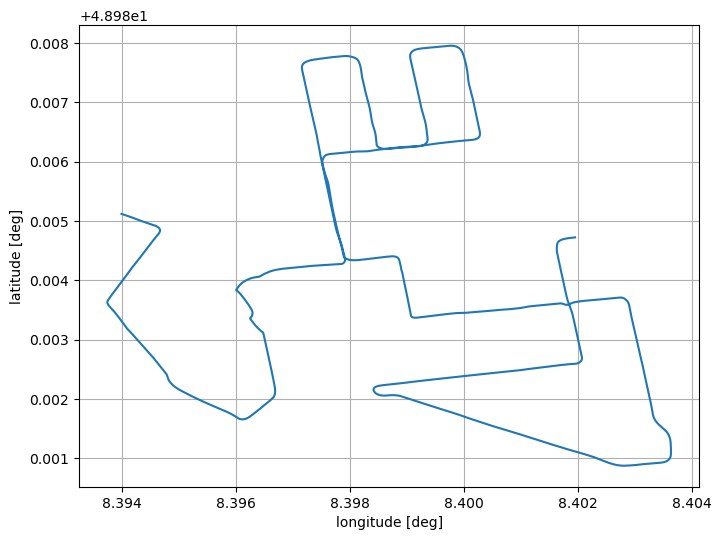

In [11]:
lons, lats, _ = gt_trajectory_lla

fig, ax = plt.subplots(1, 1, figsize=(8, 6))#fig, ax：这个语法表示 plt.subplots() 返回两个对象：
                                            #fig：图形对象 Figure。
                                            #ax：绘图区域 Axes。当创建多于一个子图时，ax 会是一个数组或类似对象，包含所有的子图。
                                            #1, 1：表示你想创建的子图的布局是 1 行 1 列，也就是说，只有一个子图（ax 对象）。
                                            #如果你设置为 2, 2，则会创建一个 2x2 的子图矩阵，你将获得 4 个 ax 对象，分别对应不同的位置。
ax.plot(lons, lats)
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('latitude [deg]')
ax.grid();

Transform GPS trajectory from [lon, lat, alt] to local [x, y, z] coord so that Kalman filter can handle it.

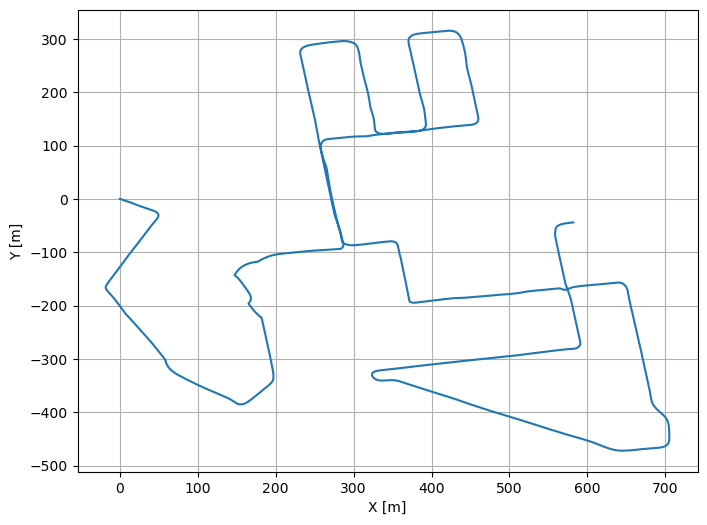

In [12]:
origin = gt_trajectory_lla[:, 0]  # set the initial position to the origin
gt_trajectory_xyz = lla_to_enu(gt_trajectory_lla, origin)#lla_to_enu() 函数来自于utils文件，作用是将 地理坐标系（经度、纬度、海拔）转换为 ENU 局部坐标系（东、北、天）。
                                                         #lla_to_enu(gt_trajectory_lla, origin) 函数接受两个参数：
                                                         #gt_trajectory_lla：所有时间点的地理坐标。
                                                         #origin：转换时使用的原点（第一个位置点 lon_0, lat_0, alt_0）。

xs, ys, _ = gt_trajectory_xyz   #ENU 坐标系简介：
                                #E（East）: 东向坐标（X 方向）。
                                #N（North）: 北向坐标（Y 方向）。
                                #U（Up）: 向上的垂直坐标（Z 方向）。
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(xs, ys)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.grid();

Extract timestamps from KITTI data and convert them to seconds elapsed from the first one.

In [13]:
timestamps = np.array(dataset.timestamps)
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed]

### Plot ground-truth yaw angles, yaw rates, and forward velocitis 

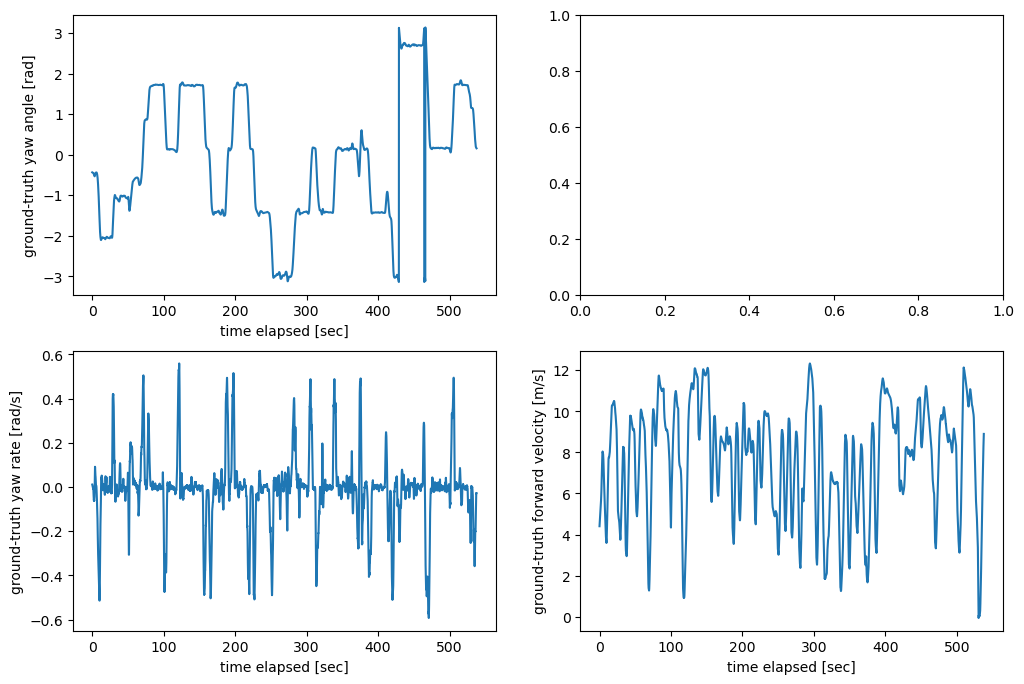

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(ts, gt_yaws)
ax[0, 0].set_xlabel('time elapsed [sec]')
ax[0, 0].set_ylabel('ground-truth yaw angle [rad]')

ax[1, 0].plot(ts, gt_yaw_rates)
ax[1, 0].set_xlabel('time elapsed [sec]')
ax[1, 0].set_ylabel('ground-truth yaw rate [rad/s]')

ax[1, 1].plot(ts, gt_forward_velocities)
ax[1, 1].set_xlabel('time elapsed [sec]')
ax[1, 1].set_ylabel('ground-truth forward velocity [m/s]');

## Add gaussian noise to KITTI GPU/IMU data

Add gaussian noise to the ground-truth GPS/IMU data.

Those are used as noisy observations given to Kalman filter later.

### Add noise to GPS data

In [15]:
N = len(ts)  # number of data point

In [16]:
xy_obs_noise_std = 5.0  # standard deviation of observation noise of x and y in meter

xy_obs_noise = np.random.normal(0.0, xy_obs_noise_std, (2, N))  # gen gaussian noise
obs_trajectory_xyz = gt_trajectory_xyz.copy()
obs_trajectory_xyz[:2, :] += xy_obs_noise  # add the noise to ground-truth positions

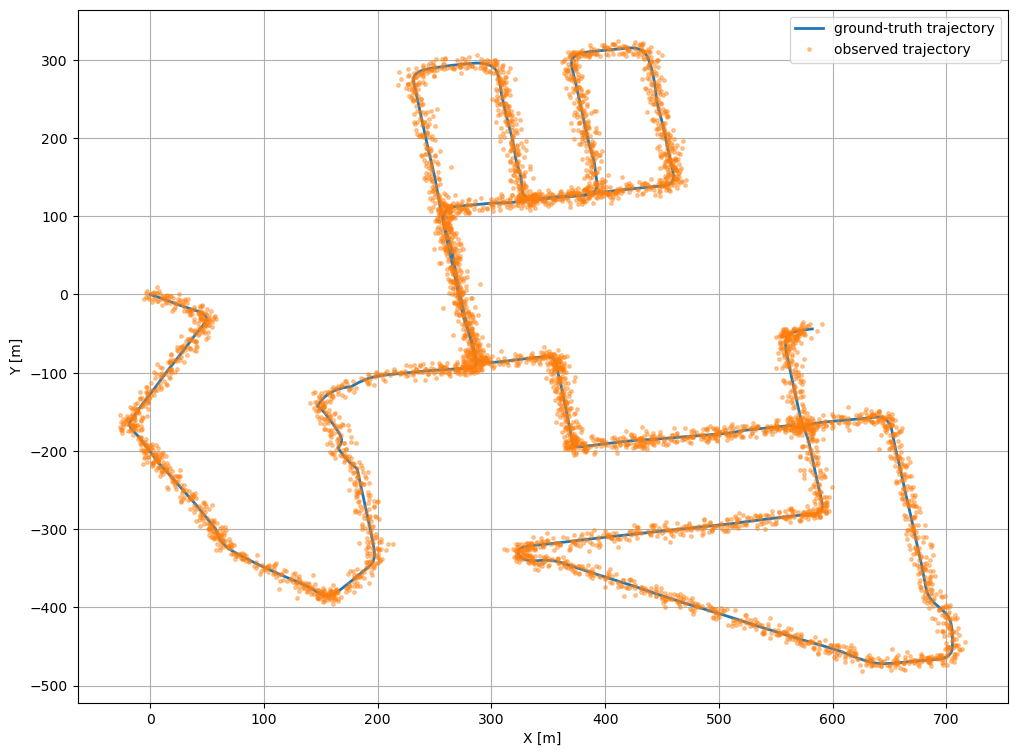

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = obs_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=5, alpha=0.4, label='observed trajectory')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid();

### Add noise to yaw rates

In [18]:
yaw_rate_noise_std = 0.02 # standard deviation of yaw rate in rad/s

yaw_rate_noise = np.random.normal(0.0, yaw_rate_noise_std, (N,))  # gen gaussian noise
obs_yaw_rates = gt_yaw_rates.copy()
obs_yaw_rates += yaw_rate_noise  # add the noise to ground-truth positions

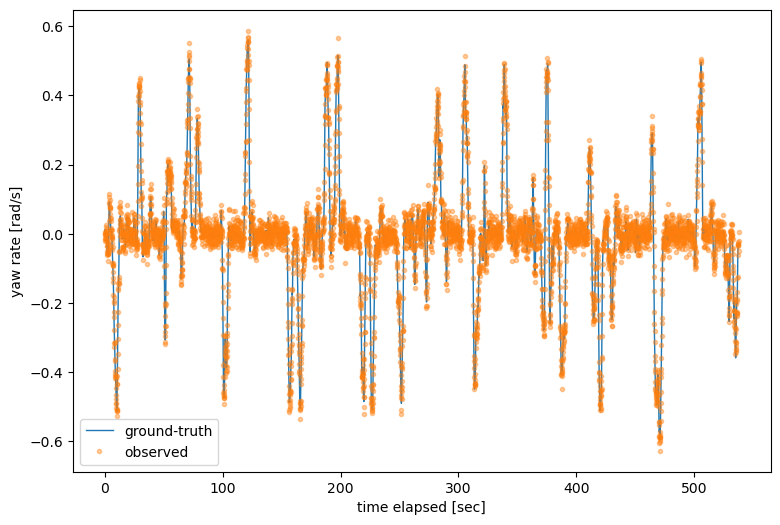

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_yaw_rates, lw=1, label='ground-truth')
ax.plot(ts, obs_yaw_rates, lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('yaw rate [rad/s]')
ax.legend();

### Add noise to forward velocities

In [20]:
forward_velocity_noise_std = 0.3 # standard deviation of forward velocity in m/s

forward_velocity_noise = np.random.normal(0.0, forward_velocity_noise_std, (N,))  # gen gaussian noise
obs_forward_velocities = gt_forward_velocities.copy()
obs_forward_velocities += forward_velocity_noise  # add the noise to ground-truth positions

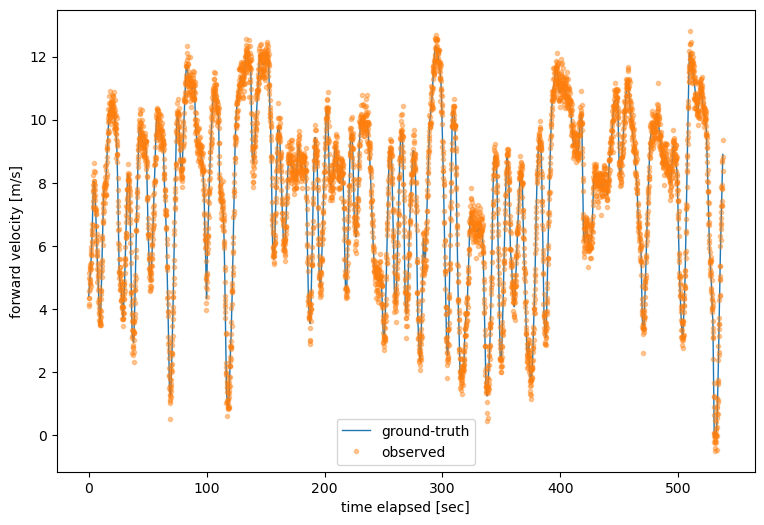

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_forward_velocities, lw=1, label='ground-truth')
ax.plot(ts, obs_forward_velocities, lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('forward velocity [m/s]')
ax.legend();

## Apply Kalman filter!

Let's apply Kalman filter to the GPS/IMU sequence to estimate vehicle 2d pose [x, y, theta].

Be aware that the ground-truth data is used only for the evaluation. i.e., only noised GPS/IMU sequence is given to the filter.

### Prepare initial estimate and its error covariance

Suppose initial 2d position [x, y] estimation are initialized with the first GPS observation.

Since our vehicle has no sensor to measure yaw angle, yaw estimation is initialized randomly and its variance is initialized with some large value (e.g. pi).

In [22]:
# initial state x_0

initial_yaw_std = np.pi
initial_yaw = gt_yaws[0] + np.random.normal(0, initial_yaw_std)

x = np.array([
    obs_trajectory_xyz[0, 0],
    obs_trajectory_xyz[1, 0],
    initial_yaw
])

In [23]:
# covariance for initial state estimation error (Sigma_0)
# P 是初始状态估计误差的协方差矩阵。
# P 是一个 3x3 的矩阵，对应的是初始状态 x = [x, y, yaw] 的不确定性

P = np.array([
    [xy_obs_noise_std ** 2., 0., 0.],
    [0., xy_obs_noise_std ** 2., 0.],
    [0., 0., initial_yaw_std ** 2.]
])

### Prepare measuerment error covariance Q

In [24]:
#Q 是观测噪声（测量噪声）的协方差矩阵。
Q = np.array([
    [xy_obs_noise_std ** 2., 0.],
    [0., xy_obs_noise_std ** 2.]
])

### Prepare state transition noise covariance R

In [25]:
#R 是状态转移噪声（过程噪声）的协方差矩阵。
R = np.array([
    [forward_velocity_noise_std ** 2., 0., 0.],
    [0., forward_velocity_noise_std ** 2., 0.],
    [0., 0., yaw_rate_noise_std ** 2.]
])


### Kalman filter main routine

In [26]:
# initialize Kalman filter
kf = EKF(x, P)

# array to store estimated 2d pose [x, y, theta]
mu_x = [x[0],]
mu_y = [x[1],]
mu_theta = [x[2],]

# array to store estimated error variance of 2d pose
var_x = [P[0, 0],]
var_y = [P[1, 1],]
var_theta = [P[2, 2],]

t_last = 0.
for t_idx in range(1, N):
    t = ts[t_idx]
    dt = t - t_last
    
    # get control input `u = [v, omega] + noise`
    u = np.array([                       #控制输入u,用于预测车辆的下一时刻状态
        obs_forward_velocities[t_idx],   #当前时间点的前向速度 v
        obs_yaw_rates[t_idx]             #当前时间点的偏航角速率 omega
                                         #！卡尔曼滤波器的预测步骤就是基于上一个时间点的状态估计 x 和协方差矩阵 P，
                                         #！并结合当前时间点的控制输入 u = [v, \omega] 
                                         #！来预测当前时间点的状态 x 和协方差矩阵 P
    ])
    
    # because velocity and yaw rate are multiplied with `dt` in state transition function,
    # its noise covariance must be multiplied with `dt**2.`
    R_ = R * (dt ** 2.) #由于控制输入 v 和 omega 乘以了时间步长 dt 来计算位置和偏航角的变化，
                        #因此噪声协方差矩阵 R 也需要乘以 dt^2 来适应时间步长的影响。
                        #这样做可以调整噪声的大小，使得它与实际的时间步长匹配。
                        #！因为dt每次循环值不同，所以R_要写在循环里
    
    # propagate!
    kf.propagate(u, dt, R_)   #调用卡尔曼滤波器的预测步骤，根据控制输入 u 和过程噪声 R，预测下一个时刻的状态。
                              #更新了主循环状态向量x和P，即kf.x和kf.P
                              #propagate 方法就是你使用的运动模型
    
    # get measurement `z = [x, y] + noise`
    z = np.array([                     #这是在当前时间步获得的观测数据，表示车辆的当前位置（X 和 Y 坐标）。来自GPS
        obs_trajectory_xyz[0, t_idx],
        obs_trajectory_xyz[1, t_idx]
    ])
    
    # update!
    kf.update(z, Q)          #观测数据 z 和之前的预测状态 kf.x 会被结合在一起，计算出新的状态估计 kf.x（以及kf.P）
    
    # save estimated state to analyze later
    mu_x.append(kf.x[0])
    mu_y.append(kf.x[1])
    mu_theta.append(normalize_angles(kf.x[2]))
    
    # save estimated variance to analyze later
    var_x.append(kf.P[0, 0])
    var_y.append(kf.P[1, 1])
    var_theta.append(kf.P[2, 2])
    
    t_last = t
    
#mu_x, mu_y, mu_theta：存储每个时间步的状态估计
mu_x = np.array(mu_x)     
mu_y = np.array(mu_y)
mu_theta = np.array(mu_theta)

#var_x, var_y, var_theta：存储每个时间步的状态不确定性（方差）
var_x = np.array(var_x)
var_y = np.array(var_y)
var_theta = np.array(var_theta)

## Visualize estimated results

### trajectory

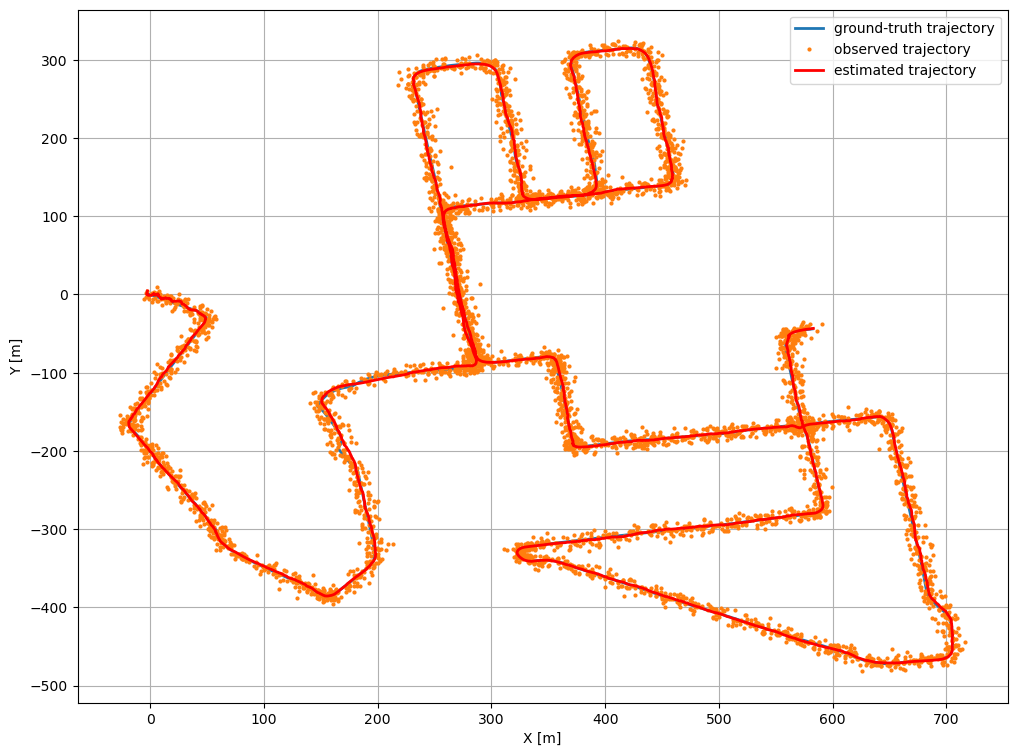

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = obs_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory')

ax.plot(mu_x, mu_y, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

### Analyze estimation error of X

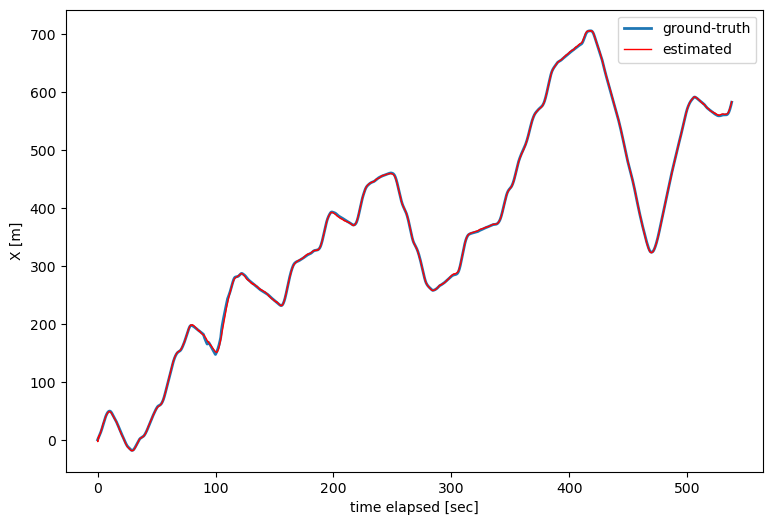

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_trajectory_xyz[0], lw=2, label='ground-truth')
#ax.plot(ts, obs_trajectory_xyz[0], lw=0, marker='.', markersize=3, alpha=0.4, label='observed')
ax.plot(ts, mu_x, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('X [m]')
ax.legend();

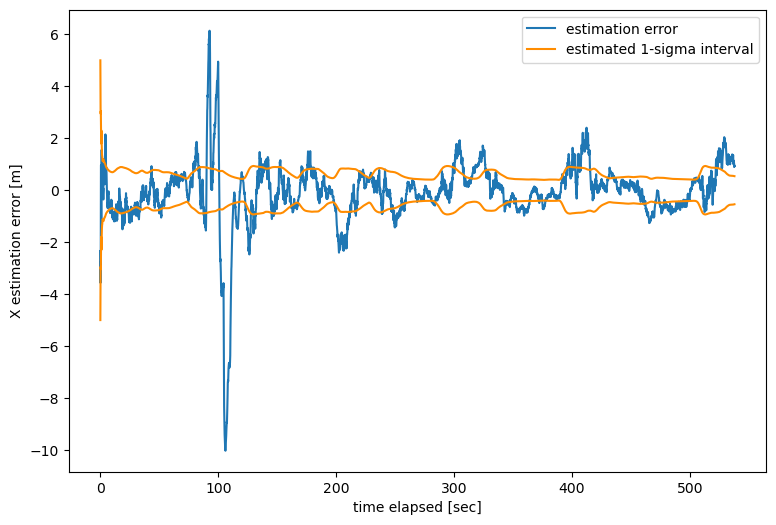

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, mu_x - gt_trajectory_xyz[0], lw=1.5, label='estimation error')
ax.plot(ts, np.sqrt(var_x), lw=1.5, label='estimated 1-sigma interval', color='darkorange')
ax.plot(ts, -np.sqrt(var_x), lw=1.5, label='', color='darkorange')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('X estimation error [m]')
ax.legend();

### Analyze estimation error of Y

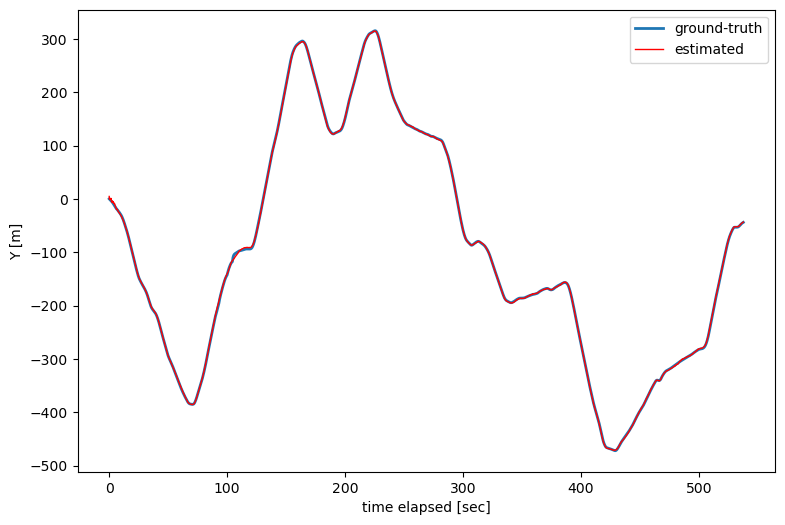

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_trajectory_xyz[1], lw=2, label='ground-truth')
#ax.plot(ts, obs_trajectory_xyz[1], lw=0, marker='.', markersize=3, alpha=0.4, label='observed')
ax.plot(ts, mu_y, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('Y [m]')
ax.legend();

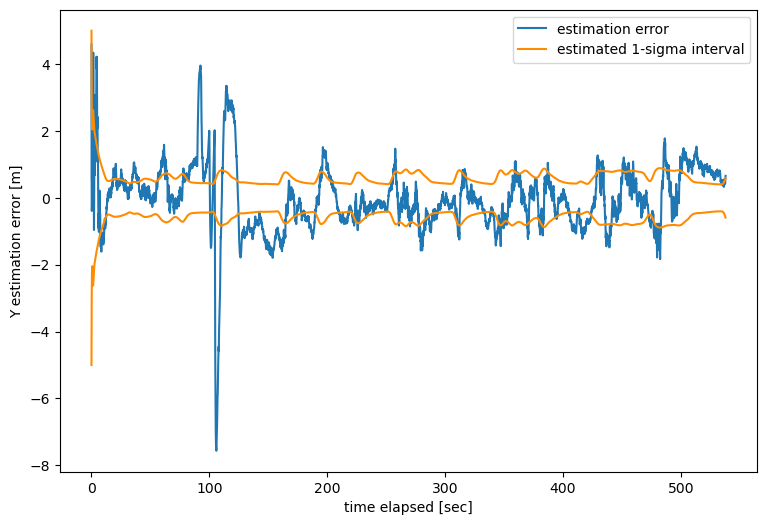

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, mu_y - gt_trajectory_xyz[1], lw=1.5, label='estimation error')
ax.plot(ts, np.sqrt(var_y), lw=1.5, label='estimated 1-sigma interval', color='darkorange')
ax.plot(ts, -np.sqrt(var_y), lw=1.5, label='', color='darkorange')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('Y estimation error [m]')
ax.legend();

### Analyze estimation error of Theta

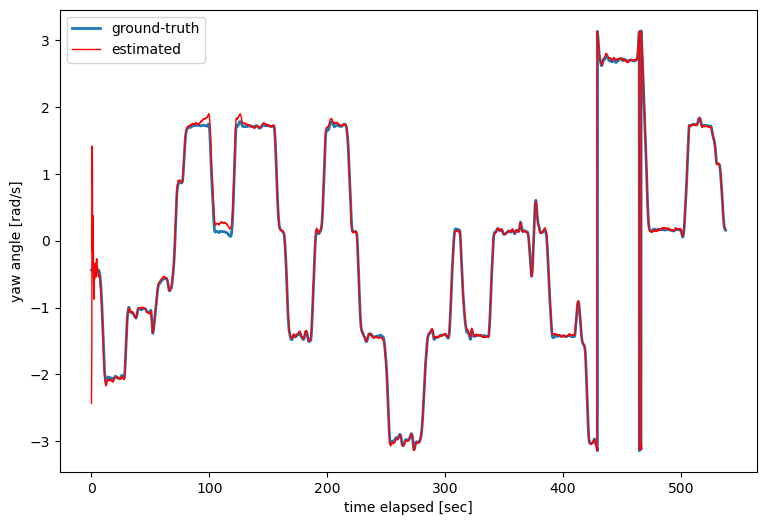

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_yaws, lw=2, label='ground-truth')
ax.plot(ts, mu_theta, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('yaw angle [rad/s]')
ax.legend();

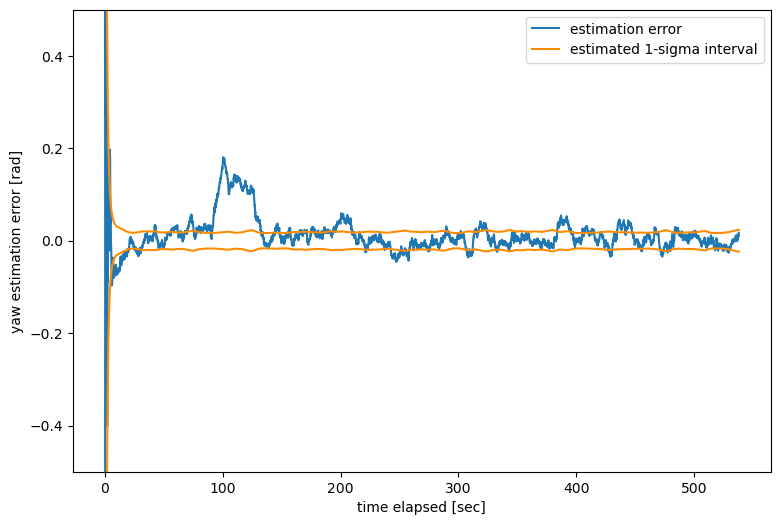

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, normalize_angles(mu_theta - gt_yaws), lw=1.5, label='estimation error')
ax.plot(ts, np.sqrt(var_theta), lw=1.5, label='estimated 1-sigma interval', color='darkorange')
ax.plot(ts, -np.sqrt(var_theta), lw=1.5, label='', color='darkorange')

ax.set_ylim(-0.5, 0.5)

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('yaw estimation error [rad]')
ax.legend();

## Optional: generate Folium of vehicle trajectory

In [34]:
import folium
import geopandas as gpd
from shapely.geometry import LineString
from utils import enu_to_lla

# 定义函数创建 GeoDataFrame
def dump_to_geodataframe(longitudes, latitudes):
    geometry = []
    for i in range(1, len(longitudes)):
        lon, lat = longitudes[i], latitudes[i]
        lon_prev, lat_prev = longitudes[i - 1], latitudes[i - 1]
        geometry.append(
            LineString([
                (lon_prev, lat_prev),
                (lon, lat)
            ])
        )
    return gpd.GeoDataFrame(geometry=geometry)

# 创建 GeoDataFrame
gdf_gt = dump_to_geodataframe(gt_trajectory_lla[0], gt_trajectory_lla[1])

# 确保正确的经纬度顺序（纬度在前，符合 Folium 规范）
def line_to_folium_coords(line):
    return [(lat, lon) for lon, lat in line.coords]

# 创建 Folium 地图，设置初始视角为轨迹的起点
m = folium.Map(location=[gt_trajectory_lla[1][0], gt_trajectory_lla[0][0]], zoom_start=13)

# 为每条轨迹添加到地图上
for line in gdf_gt.geometry:
    folium.PolyLine(line_to_folium_coords(line), color="blue", weight=2.5, opacity=1).add_to(m)

# 在 Jupyter Notebook 中显示交互式地图
m